In [18]:
import pandas as pd
import numpy as np
import os

In [19]:
data_path = os.getcwd() + "/dataset/total_concentrated.csv"
features = ["A_F", "A_V", "A_L", "L_F", "L_T", "L_L", "T_F", "T_V", "T_L"]

dataset = pd.read_csv(data_path)
dataframe = pd.read_csv(data_path)
dataset = dataset[["A_F", "A_V", "A_L", "L_F", "L_V", "L_L", "T_F", "T_V", "T_L", "Action"]].values

window_length = int(1*64)
total_windows = int((len(dataset))/window_length)

In [20]:
indices = list(dataframe['time'])
groups = []
group_count = 0
temp = []
lenOfGroup = []
length_count = 0

for i in range(len(indices)):
    if i == (len(indices) - 1):
        temp.append(indices[i])
        length_count = length_count + 1

        groups.append(temp)
        lenOfGroup.append(length_count)
        length_count = 0
        temp = []
        break
    temp.append(indices[i])
    length_count = length_count + 1
    if (indices[i+1] - 20 > indices[i]):
        group_count = group_count + 1

        lenOfGroup.append(length_count)
        length_count = 0

        groups.append(temp)
        temp = []

del temp, indices, group_count, length_count, i

In [21]:
countOfUndivisible = 0
total_windows_with_overlap = 0

start_index = 0

stop_Indexs = []
stop_Index = -window_length


for lengths in lenOfGroup:
    stop_Index = stop_Index + lengths
    stop_Indexs.append(stop_Index)
    total_windows_with_overlap = total_windows_with_overlap + int(lengths/window_length*2 -1)
    
    if lengths % (window_length/2) != 0:
        countOfUndivisible = countOfUndivisible + 1
        print(lengths)

print(countOfUndivisible)
del countOfUndivisible, lengths

0


In [22]:
X = np.empty((total_windows_with_overlap, window_length*9))
y = np.empty((total_windows_with_overlap, 1))
j = 0

stop_Index = 0
window_count = 0

for window in range(total_windows_with_overlap):
    for i in range(window_length):
        if i == 0:
            y[window] = dataset[int(window_count*window_length), 9]
        
        if int(window_count*window_length)<len(dataset)-window_length-1:
            for data in range(9):
               X[window, i*9 + data] = dataset[int(window_count*window_length) + i, data]
        if stop_Index < len(stop_Indexs):
            if int(window_count*window_length) == stop_Indexs[stop_Index]:
                window_count = window_count + 0.5
                stop_Index = stop_Index + 1
    window_count = window_count + 0.5

del window_count, i, j, window, data

In [23]:
from sklearn.model_selection import (
    TimeSeriesSplit,
    KFold,
    ShuffleSplit,
    StratifiedKFold,
    GroupShuffleSplit,
    GroupKFold,
    StratifiedShuffleSplit,
    StratifiedGroupKFold,
)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

np.random.seed(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 3

In [24]:
unique, counts = np.unique(y, return_counts=True)
for i in range(3):
    print ("[{}, {}]".format(int(unique[i]), counts[i]))

[0, 21469]
[1, 3127]
[2, 246]


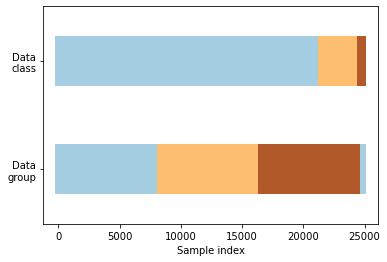

In [34]:
# Generate the class/group data
n_points = total_windows
# X = np.random.randn(100, 10)

y = np.hstack(y)

groups = np.empty((len(X)))
k=0
# Evenly spaced groups repeated once
for i in range(3):
    for j in range(int(len(X)/3)):
        groups[i*int(len(X)/3) + j] = k
    k = k + 1


def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )


visualize_groups(y, groups, "no groups")

In [30]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, len(X)],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

<AxesSubplot:title={'center':'KFold'}, xlabel='Sample index', ylabel='CV iteration'>

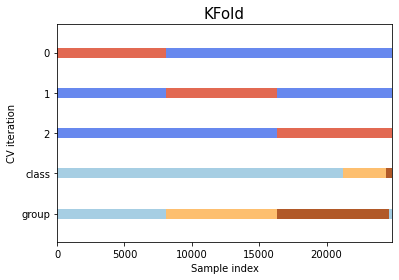

In [35]:
fig, ax = plt.subplots()
cv = KFold(n_splits)
plot_cv_indices(cv, X, y, groups, ax, n_splits)

ValueError: Found input variables with inconsistent numbers of samples: [24842, 24842, 12770]

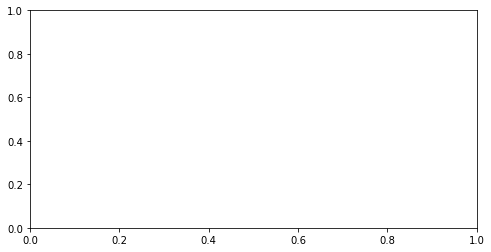

In [36]:
# To better demonstrate the difference, we will assign samples to groups
# unevenly:

uneven_groups = np.sort(np.random.randint(0, 10, n_points))

cvs = [StratifiedKFold, GroupKFold, StratifiedGroupKFold]

for cv in cvs:
    fig, ax = plt.subplots(figsize=(8, 4))
    plot_cv_indices(cv(n_splits), X, y, uneven_groups, ax, n_splits)
    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=1)

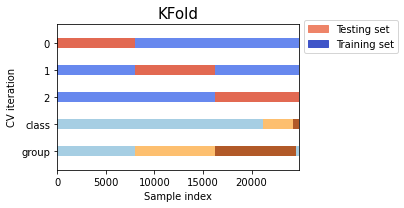

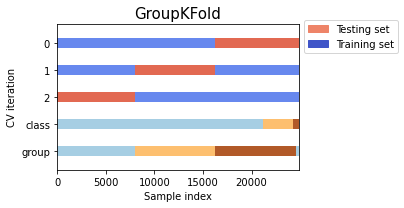

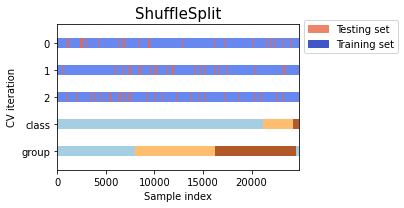

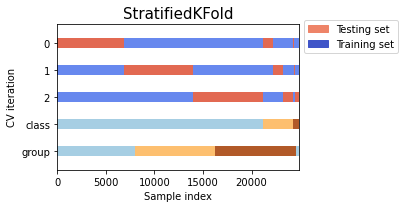

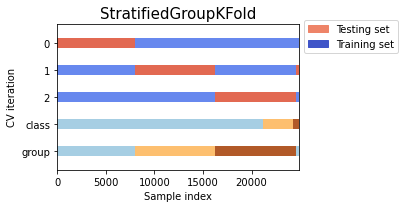

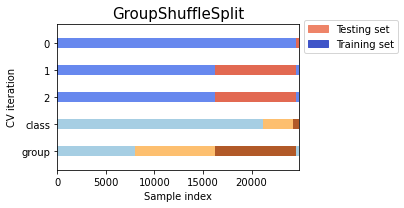

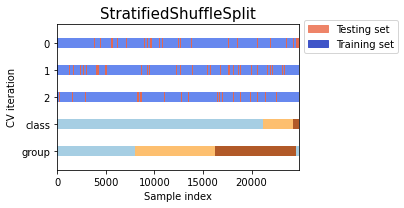

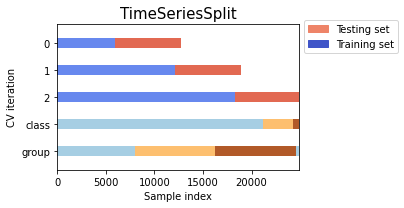

In [37]:
cvs = [
    KFold,
    GroupKFold,
    ShuffleSplit,
    StratifiedKFold,
    StratifiedGroupKFold,
    GroupShuffleSplit,
    StratifiedShuffleSplit,
    TimeSeriesSplit,
]


for cv in cvs:
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(6, 3))
    plot_cv_indices(this_cv, X, y, groups, ax, n_splits)

    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)
plt.show()